## Libraries we need
Install tf_pose and pycocotools

In [15]:
!pip install -qq git+https://www.github.com/ildoonet/tf-pose-estimation

In [16]:
!pip install -qq pycocotools

In [17]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%matplotlib inline
import tf_pose
import cv2
from glob import glob
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
import os
import math

In [19]:
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
tfpe = tf_pose.get_estimator()

In [20]:
DEF_SHAPE = 256

In [144]:
im_side = cv2.imread('../input/pose-detection/unnamed.jpg')
res_side = cv2.resize(im_side, dsize=(DEF_SHAPE,DEF_SHAPE))
#print(im_side.shape)
# print(res_side.shape)

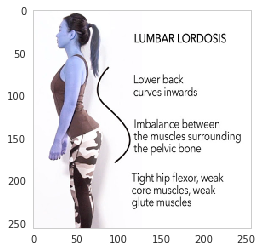

In [145]:
plt.imshow(res_side)

In [146]:
pts_side = tfpe.inference(npimg=res_side, upsample_size=4.0)
print(pts_side)

[BodyPart:0-(0.11, 0.10) score=0.69 BodyPart:1-(0.20, 0.23) score=0.56 BodyPart:2-(0.22, 0.23) score=0.45 BodyPart:5-(0.19, 0.24) score=0.73 BodyPart:6-(0.17, 0.42) score=0.86 BodyPart:7-(0.11, 0.59) score=0.78 BodyPart:8-(0.24, 0.57) score=0.17 BodyPart:11-(0.23, 0.58) score=0.38 BodyPart:12-(0.22, 0.82) score=0.48 BodyPart:13-(0.24, 0.98) score=0.21 BodyPart:15-(0.12, 0.09) score=0.75 BodyPart:17-(0.18, 0.11) score=0.82]


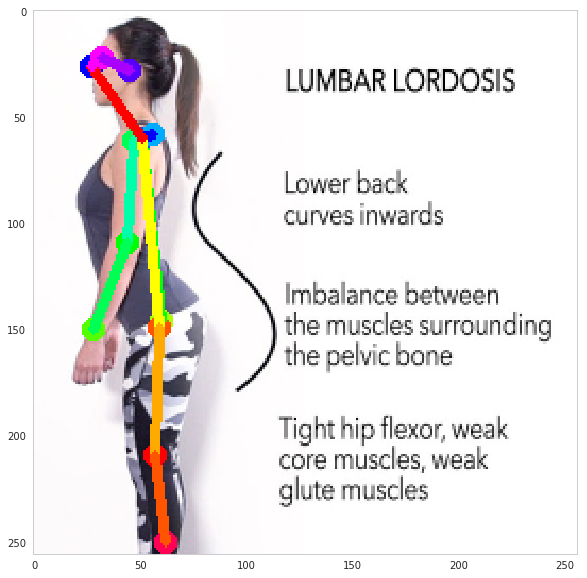

In [147]:
new_image = TfPoseEstimator.draw_humans(res_side, pts_side, imgcopy=False)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(new_image[:, :, ::-1])

In [148]:
body_to_dict = lambda c_fig: {'bp_{}_{}'.format(k, vec_name): vec_val 
                              for k, part_vec in c_fig.body_parts.items() 
                              for vec_name, vec_val in zip(['x', 'y', 'score'],
                                                           (part_vec.x, 1-part_vec.y, part_vec.score))}
c_fig_side = pts_side[0]
body_to_dict(c_fig_side)

{'bp_0_x': 0.10648148148148148,
 'bp_0_y': 0.8967391304347826,
 'bp_0_score': 0.6912199854850769,
 'bp_1_x': 0.19907407407407407,
 'bp_1_y': 0.7663043478260869,
 'bp_1_score': 0.5642011165618896,
 'bp_2_x': 0.2175925925925926,
 'bp_2_y': 0.7717391304347826,
 'bp_2_score': 0.45461806654930115,
 'bp_5_x': 0.18518518518518517,
 'bp_5_y': 0.7608695652173914,
 'bp_5_score': 0.7281243801116943,
 'bp_6_x': 0.1712962962962963,
 'bp_6_y': 0.5760869565217391,
 'bp_6_score': 0.8584830164909363,
 'bp_7_x': 0.1111111111111111,
 'bp_7_y': 0.4130434782608695,
 'bp_7_score': 0.7782886624336243,
 'bp_8_x': 0.2361111111111111,
 'bp_8_y': 0.42934782608695654,
 'bp_8_score': 0.17024023830890656,
 'bp_11_x': 0.23148148148148148,
 'bp_11_y': 0.4184782608695652,
 'bp_11_score': 0.37957558035850525,
 'bp_12_x': 0.2222222222222222,
 'bp_12_y': 0.18478260869565222,
 'bp_12_score': 0.4826923906803131,
 'bp_13_x': 0.24074074074074073,
 'bp_13_y': 0.021739130434782594,
 'bp_13_score': 0.20856745541095734,
 'bp_15_

In [149]:
# print(pts_side[0].body_parts.items())

In [150]:
count = 0
shldr=[0,0]
hip=[0,0]
knee=[0,0]
ear=[0,0]
for k, part_vec in pts_side[0].body_parts.items():
    if k==5:
        count+=1
        shldr[0]=part_vec.x
        shldr[1]=part_vec.y
    if k==11:
        count+=1
        hip[0]=part_vec.x
        hip[1]=part_vec.y
    if k==12:
        count+=1
        knee[0]=part_vec.x
        knee[1]=part_vec.y
    if k==17:
        count+=1
        ear[0]=part_vec.x
        ear[1]=part_vec.y

In [151]:
if count<4:
    print("image not ideal for work")

# Front head angle
in degrees

In [152]:
def length(arr1,arr2):
    return (math.sqrt((arr1[0]-arr2[0])**2+(arr1[1]-arr2[1])**2))

In [153]:
ang =math.acos((((ear[0]-shldr[0])*(shldr[0]-hip[0]))+((ear[1]-shldr[1])*(shldr[1]-hip[1])))/
               ((length(ear,shldr))*(length(shldr, hip))))
ang = math.degrees(ang)*100/90

In [154]:
print(ang,"%")

4.04448926282997 %


# **Slouch Score**
ideally slouch score should be zero

In [155]:
hipt = ((knee[0]-shldr[0])/(knee[1]-shldr[1]))*(hip[1]-knee[1])+knee[0]
slch_scr = abs((hipt-hip[0])/(knee[1]-shldr[1])*100)

In [156]:
print(hipt)
print(slch_scr,"%")

0.20719776380153737
4.2152868425563375 %


# Kyphotic curve score
ideally zero

In [157]:
eart = ((hip[0]-shldr[0])/(hip[1]-shldr[1]))*(ear[1]-shldr[1])+shldr[0]
kypho_scr = abs((eart-ear[0])/(hip[1]-shldr[1])*100)

In [158]:
print(eart)
print(kypho_scr,"%")

0.1675485008818342
2.4467400128775827 %


# Swayback score
ideally zero

In [159]:
hipt = ((ear[0]-knee[0])/(ear[1]-knee[1]))*(hip[1]-ear[1])+ear[0]
lordo_scr = abs((hipt-hip[0])/(ear[1]-knee[1]))*100

In [160]:
print(hipt)
print(lordo_scr,"%")

0.20690883190883191
3.4779750164365546 %


# Knock knees/bow legs
positive score means bow legs, negative score means knock knees

In [125]:
im_front = cv2.imread('../input/pose-detection/Josh-Simson.jpg')
res_front = cv2.resize(im_front, dsize=(DEF_SHAPE,DEF_SHAPE))

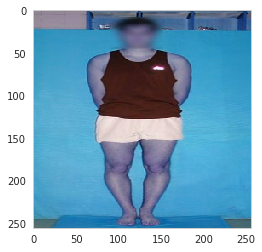

In [126]:
plt.imshow(res_front)

In [127]:
pts_front = tfpe.inference(npimg=res_front, upsample_size=4.0)
print(pts_front)

[BodyPart:0-(0.48, 0.10) score=0.46 BodyPart:1-(0.48, 0.22) score=0.66 BodyPart:2-(0.37, 0.22) score=0.48 BodyPart:3-(0.28, 0.24) score=0.70 BodyPart:4-(0.31, 0.39) score=0.32 BodyPart:5-(0.59, 0.21) score=0.51 BodyPart:6-(0.68, 0.24) score=0.60 BodyPart:7-(0.67, 0.34) score=0.41 BodyPart:8-(0.39, 0.48) score=0.31 BodyPart:9-(0.38, 0.70) score=0.70 BodyPart:10-(0.44, 0.92) score=0.73 BodyPart:11-(0.58, 0.47) score=0.31 BodyPart:12-(0.57, 0.70) score=0.63 BodyPart:13-(0.51, 0.91) score=0.58 BodyPart:14-(0.45, 0.08) score=0.52 BodyPart:15-(0.50, 0.08) score=0.51 BodyPart:16-(0.41, 0.09) score=0.54 BodyPart:17-(0.54, 0.09) score=0.51]


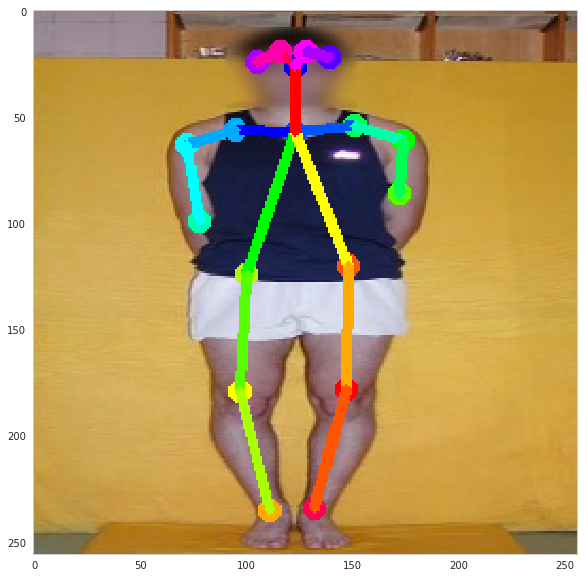

In [128]:
new_image = TfPoseEstimator.draw_humans(res_front, pts_front, imgcopy=False)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(new_image[:, :, ::-1])

In [129]:
body_to_dict = lambda c_fig: {'bp_{}_{}'.format(k, vec_name): vec_val 
                              for k, part_vec in c_fig.body_parts.items() 
                              for vec_name, vec_val in zip(['x', 'y', 'score'],
                                                           (part_vec.x, 1-part_vec.y, part_vec.score))}
c_fig_front = pts_front[0]
body_to_dict(c_fig_front)

{'bp_0_x': 0.48148148148148145,
 'bp_0_y': 0.8967391304347826,
 'bp_0_score': 0.4596680998802185,
 'bp_1_x': 0.48148148148148145,
 'bp_1_y': 0.7771739130434783,
 'bp_1_score': 0.6591029167175293,
 'bp_2_x': 0.37037037037037035,
 'bp_2_y': 0.782608695652174,
 'bp_2_score': 0.48250502347946167,
 'bp_3_x': 0.2824074074074074,
 'bp_3_y': 0.7554347826086957,
 'bp_3_score': 0.7019699215888977,
 'bp_4_x': 0.3055555555555556,
 'bp_4_y': 0.6141304347826086,
 'bp_4_score': 0.3151717185974121,
 'bp_5_x': 0.5879629629629629,
 'bp_5_y': 0.7880434782608696,
 'bp_5_score': 0.5083353519439697,
 'bp_6_x': 0.6805555555555556,
 'bp_6_y': 0.7608695652173914,
 'bp_6_score': 0.5952742099761963,
 'bp_7_x': 0.6712962962962963,
 'bp_7_y': 0.6630434782608696,
 'bp_7_score': 0.41268232464790344,
 'bp_8_x': 0.3888888888888889,
 'bp_8_y': 0.5163043478260869,
 'bp_8_score': 0.3140859007835388,
 'bp_9_x': 0.37962962962962965,
 'bp_9_y': 0.29891304347826086,
 'bp_9_score': 0.7040572166442871,
 'bp_10_x': 0.4351851851

In [130]:
count = 0
left_hip=[0,0]
right_hip=[0,0]
left_knee=[0,0]
right_knee=[0,0]
left_foot=[0,0]
right_foot=[0,0]
for k, part_vec in pts_front[0].body_parts.items():
    if k==8:
        count+=1
        right_hip[0]=part_vec.x
        right_hip[1]=part_vec.y
    if k==9:
        count+=1
        right_knee[0]=part_vec.x
        right_knee[1]=part_vec.y
    if k==10:
        count+=1
        right_foot[0]=part_vec.x
        right_foot[1]=part_vec.y
    if k==11:
        count+=1
        left_hip[0]=part_vec.x
        left_hip[1]=part_vec.y
    if k==12:
        count+=1
        left_knee[0]=part_vec.x
        left_knee[1]=part_vec.y
    if k==13:
        count+=1
        left_foot[0]=part_vec.x
        left_foot[1]=part_vec.y

In [131]:
if count<6:
    print("image not ideal to work")

In [140]:
l_knee_t = ((left_foot[0]-left_hip[0])/(left_foot[1]-left_hip[1]))*(left_knee[1]-left_foot[1])+left_foot[0]
left_leg_scr = (-1)*((l_knee_t-left_knee[0])/(left_foot[1]-left_hip[1]))*250

In [161]:
print(l_knee_t)
print(left_leg_scr,"%")

0.5455058717253839
16.026064732192054 %


In [162]:
r_knee_t = ((right_foot[0]-right_hip[0])/(right_foot[1]-right_hip[1]))*(right_knee[1]-right_foot[1])+right_foot[0]
right_leg_scr = ((r_knee_t-right_knee[0])/(right_foot[1]-right_hip[1]))*250

In [163]:
print(r_knee_t)
print(right_leg_scr,"%")

0.41203703703703703
18.634259259259245 %
